In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import arviz as az
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# In this notebook, I'm going to be showcasing the packages arviz and pymc, which are used for Bayesian statistical models.

#### Our main goal is to calculate p, when we know what the prior distribution is.
#### We usually get a result that is by itself a normal distribution, and by that we can know where p is with a percentage of certainty.

### Let's create some data to work on.

In [3]:
data = stats.binom.rvs(n=3, p=0.3, size=100)
data

array([2, 1, 0, 1, 2, 0, 1, 3, 1, 2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 3, 2, 1,
       0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 0, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1,
       3, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0,
       0, 0, 2, 0, 0, 0, 0, 3, 1, 2, 1, 0])

#### We can define a beta-binomila model

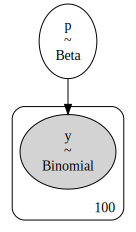

In [4]:
betabin = pm.Model()
with betabin:
    #prior 
    p = pm.Beta('p', alpha=1., beta=1.)
    #Binomial likelihood 
    y = pm.Binomial('y', n=10, p=p, observed=data)


pm.model_to_graphviz(betabin)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [p]


Output()

Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

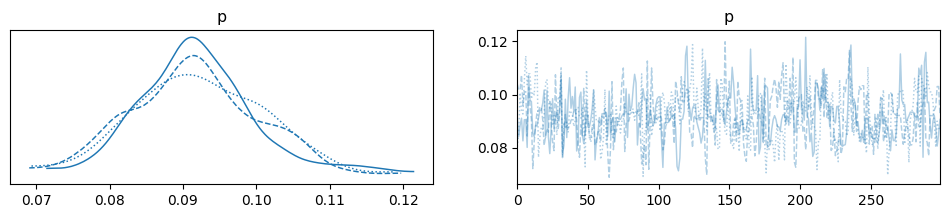

In [5]:
with betabin:
    idata = pm.sample(300, chains=3)

print(idata)
az.plot_trace(idata)

#### We can see what is our prediction for p, when using several markov chains in evaluting it (KDE).
#### We can plot the final result for p distribution: 

<Axes: title={'center': 'p'}>

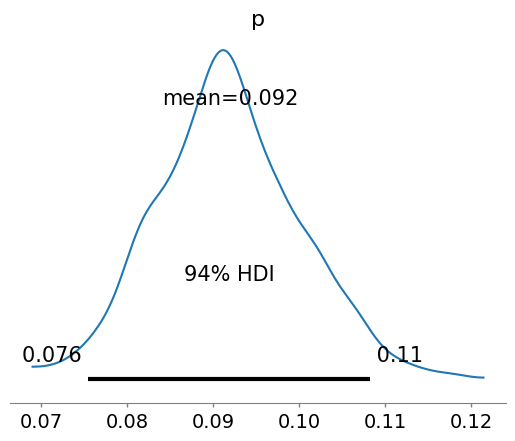

In [6]:
az.plot_posterior(idata)

#### And for a numeric evaluation:

In [7]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.092,0.009,0.076,0.108,0.0,0.0,390.0,580.0,1.01


### We can also run hypothesis testing:

({'BF10': 0.03901934723210348, 'BF01': 25.62831187440373},
 <Axes: title={'center': 'The BF_10 is 0.04\nThe BF_01 is 25.63'}, xlabel='p', ylabel='Density'>)

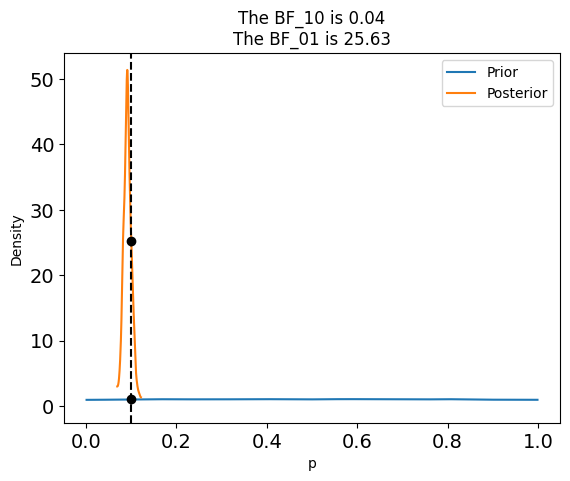

In [8]:
prior=np.random.uniform(0, 1, 10_000)

# Our hypothesis
ref_val = 0.1

# Plot Bayes Factor with the Beta prior
az.plot_bf(idata, var_name="p", prior=prior, ref_val=ref_val)

#### I got a high BF_01, meaning that H_0 is probably true, so I can say that 0.1 is the area where p is with high probability.

({'BF10': 0.050428550217238785, 'BF01': 19.83003666954824},
 <Axes: title={'center': 'The BF_10 is 0.05\nThe BF_01 is 19.83'}, xlabel='p', ylabel='Density'>)

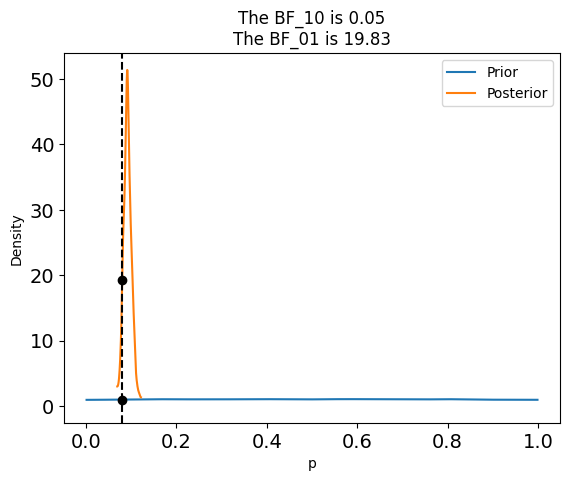

In [9]:
az.plot_bf(idata, var_name="p", prior=prior, ref_val=0.08)

#### After changing the value to 0.08, we can safely see how close we got to p.

#### Another nice thing we can do after evaluting the postrior, is the generate our own results, and plot them next to the original data.

Sampling: [y]


Output()

<Axes: xlabel='y'>

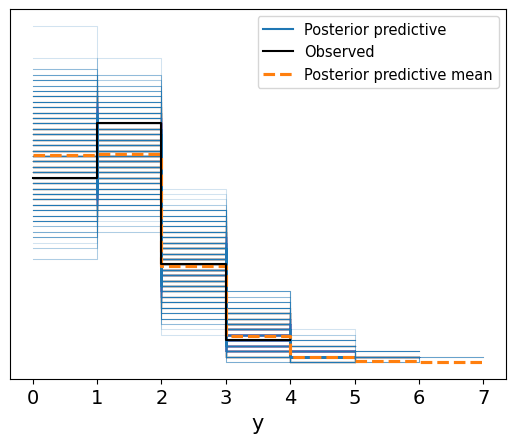

In [10]:
ppc = pm.sample_posterior_predictive(idata, model=betabin, extend_inferencedata=True)

idata.extend(ppc)

# Plot posterior predictive checks
az.plot_ppc(idata, var_names=['y'])

### So far We have seen case where we want to predict one p. Let's take a look what happened where our data is a matrix, and We need to caculate a vector of p's.

In [11]:
p_true = [0.1,0.3,0.4,0.7,0.9]

#Bernoulli distribution
data_matrix = np.array([np.random.binomial(1, p, size=100) for p in p_true])

#### Le't fit them:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


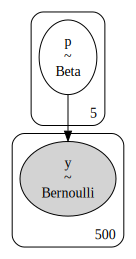

In [12]:
m = 5  # Number of different p values
n = 100  # Number of observations per p value

# Reshape 
data = data_matrix.flatten()

# Index for every p
idx = np.repeat(np.arange(m), n)

# model
betabin_vec = pm.Model()
with betabin_vec:
    # Prior 
    p = pm.Beta('p', alpha=1., beta=1., shape=m)
    
    # Bernoulli likelihood
    y = pm.Bernoulli('y', p=p[idx], observed=data)
    
    # Sampling from the posterior
    idata_vec = pm.sample(1000, chains=2, idata_kwargs={"log_likelihood": True})


pm.model_to_graphviz(betabin_vec)


#### We can look at our predicitons:

In [13]:
az.summary(idata_vec)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.088,0.028,0.044,0.146,0.001,0.000,2240.0,1392.0,1.0
p[1],0.265,0.043,0.185,0.345,0.001,0.000,4129.0,1784.0,1.0
p[2],0.354,0.046,0.264,0.432,0.001,0.001,3789.0,1439.0,1.0
p[3],0.676,0.048,0.587,0.766,0.001,0.001,2573.0,1566.0,1.0
p[4],0.931,0.025,0.884,0.975,0.000,0.000,2490.0,1736.0,1.0


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

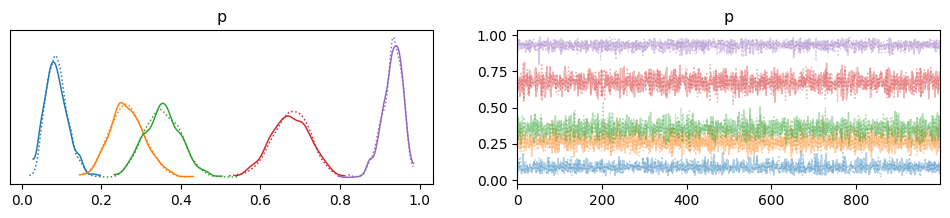

In [14]:
az.plot_trace(idata_vec)

#### And we got a vauge view of the distribution of all of the p. Let's plot them alone:

array([[<Axes: title={'center': 'p\n0'}>,
        <Axes: title={'center': 'p\n1'}>,
        <Axes: title={'center': 'p\n2'}>],
       [<Axes: title={'center': 'p\n3'}>,
        <Axes: title={'center': 'p\n4'}>, <Axes: >]], dtype=object)

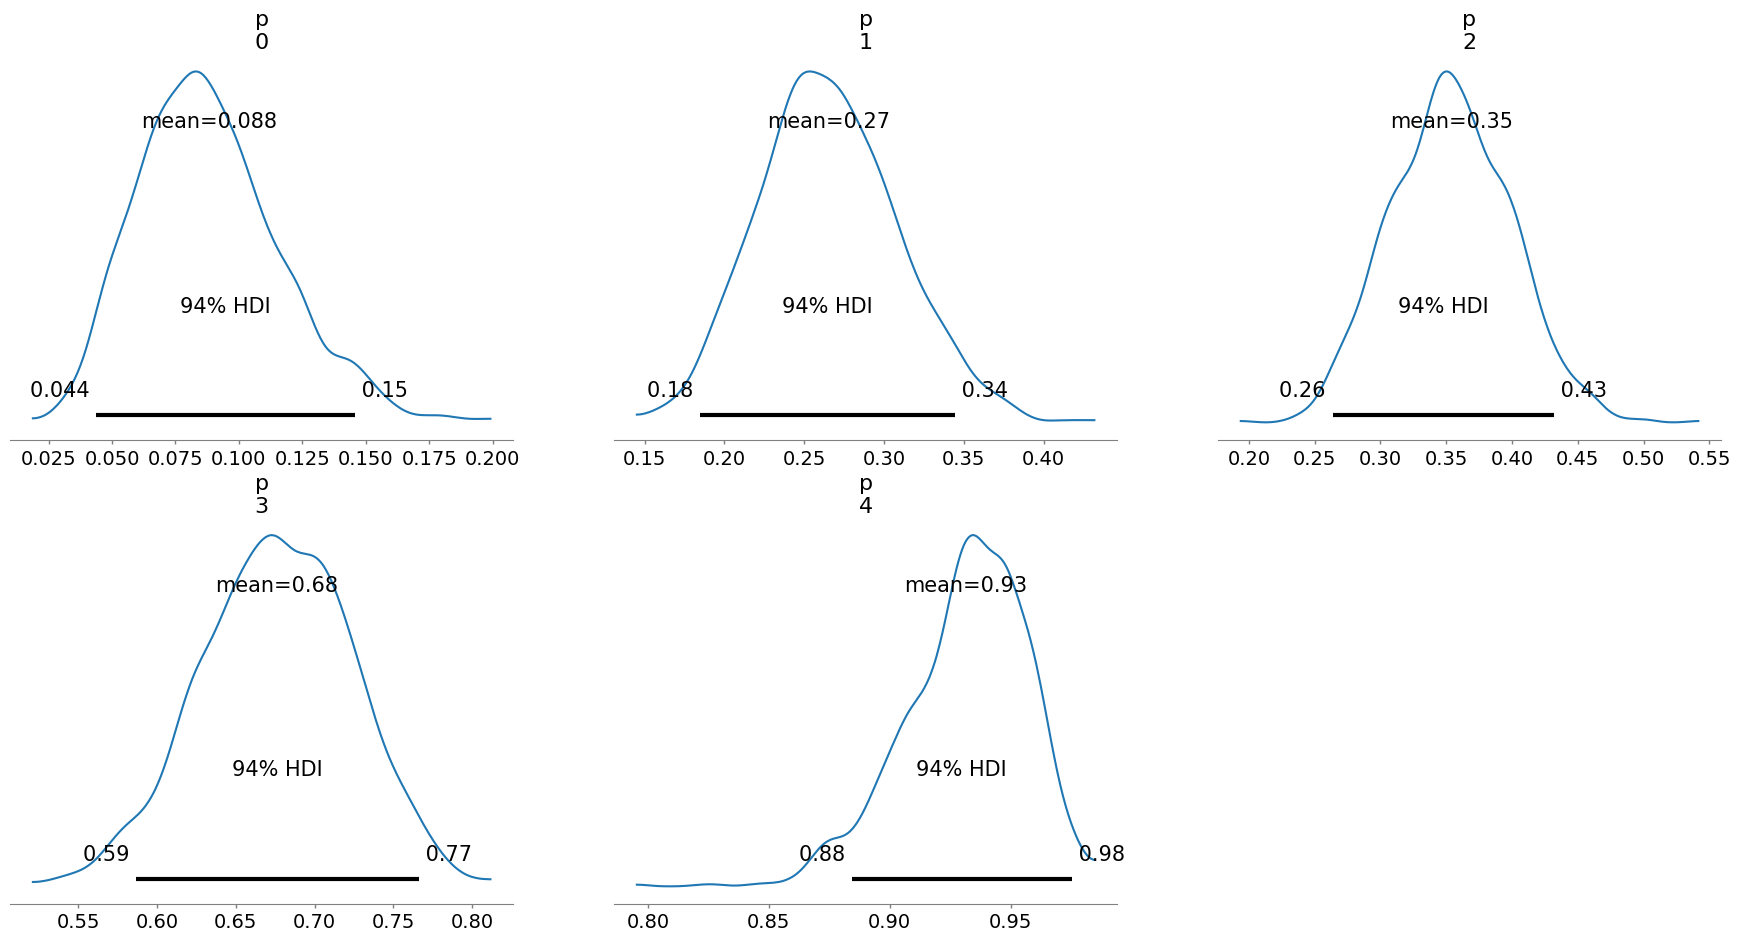

In [15]:
az.plot_posterior(idata_vec)

### What we predicted was based on the fact that all of the p were independent. Let's take a look at case where the p are actually dependent.

#### In our case, Let's sample p by using the hyper parameter alpha and beta.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, nu, p]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


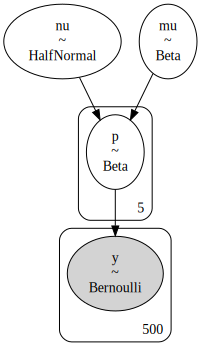

In [16]:
betabin_h = pm.Model()
with betabin_h:
    # Hyperpriors for mu and nu
    mu = pm.Beta('mu', 2., 2.)  # E[p]
    nu = pm.HalfNormal('nu', 100)  # 1/std
    
    # Calculate alpha and beta from mu and nu
    alpha = mu * nu
    beta = (1 - mu) * nu
    
    # Dependent p values modeled using the calculated alpha and beta
    p = pm.Beta('p', alpha=alpha, beta=beta, shape=m)
    
    # Likelihood using the4  Bernoulli distribution
    y = pm.Bernoulli('y', p=p[idx], observed=data)
    
    # Sampling from the posterior
    idata_h = pm.sample(1000, chains=2, idata_kwargs={"log_likelihood": True})

# Visualize the model structure
pm.model_to_graphviz(betabin_h)


#### Let's plot the result:

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

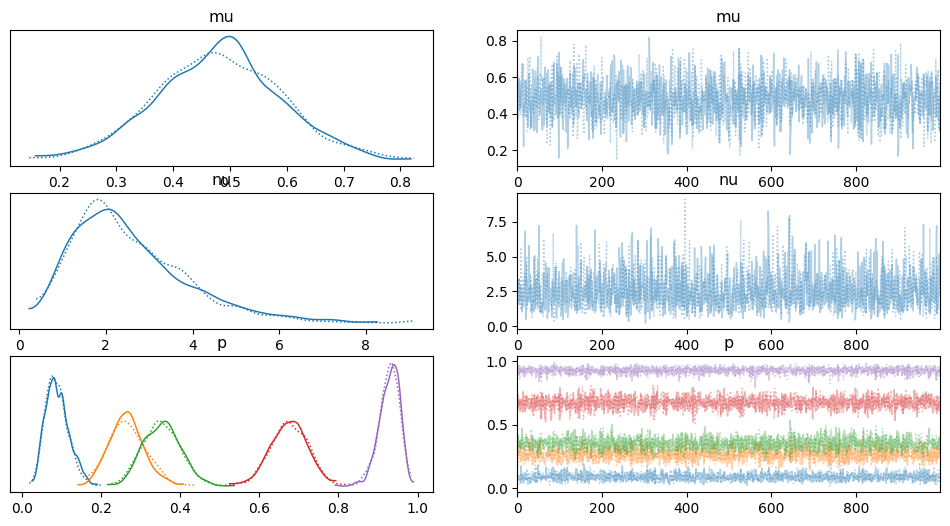

In [17]:
az.plot_trace(idata_h)

#### And we got a posterior for mu, nu and our p's.

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'nu'}>,
        <Axes: title={'center': 'p\n0'}>],
       [<Axes: title={'center': 'p\n1'}>,
        <Axes: title={'center': 'p\n2'}>,
        <Axes: title={'center': 'p\n3'}>],
       [<Axes: title={'center': 'p\n4'}>, <Axes: >, <Axes: >]],
      dtype=object)

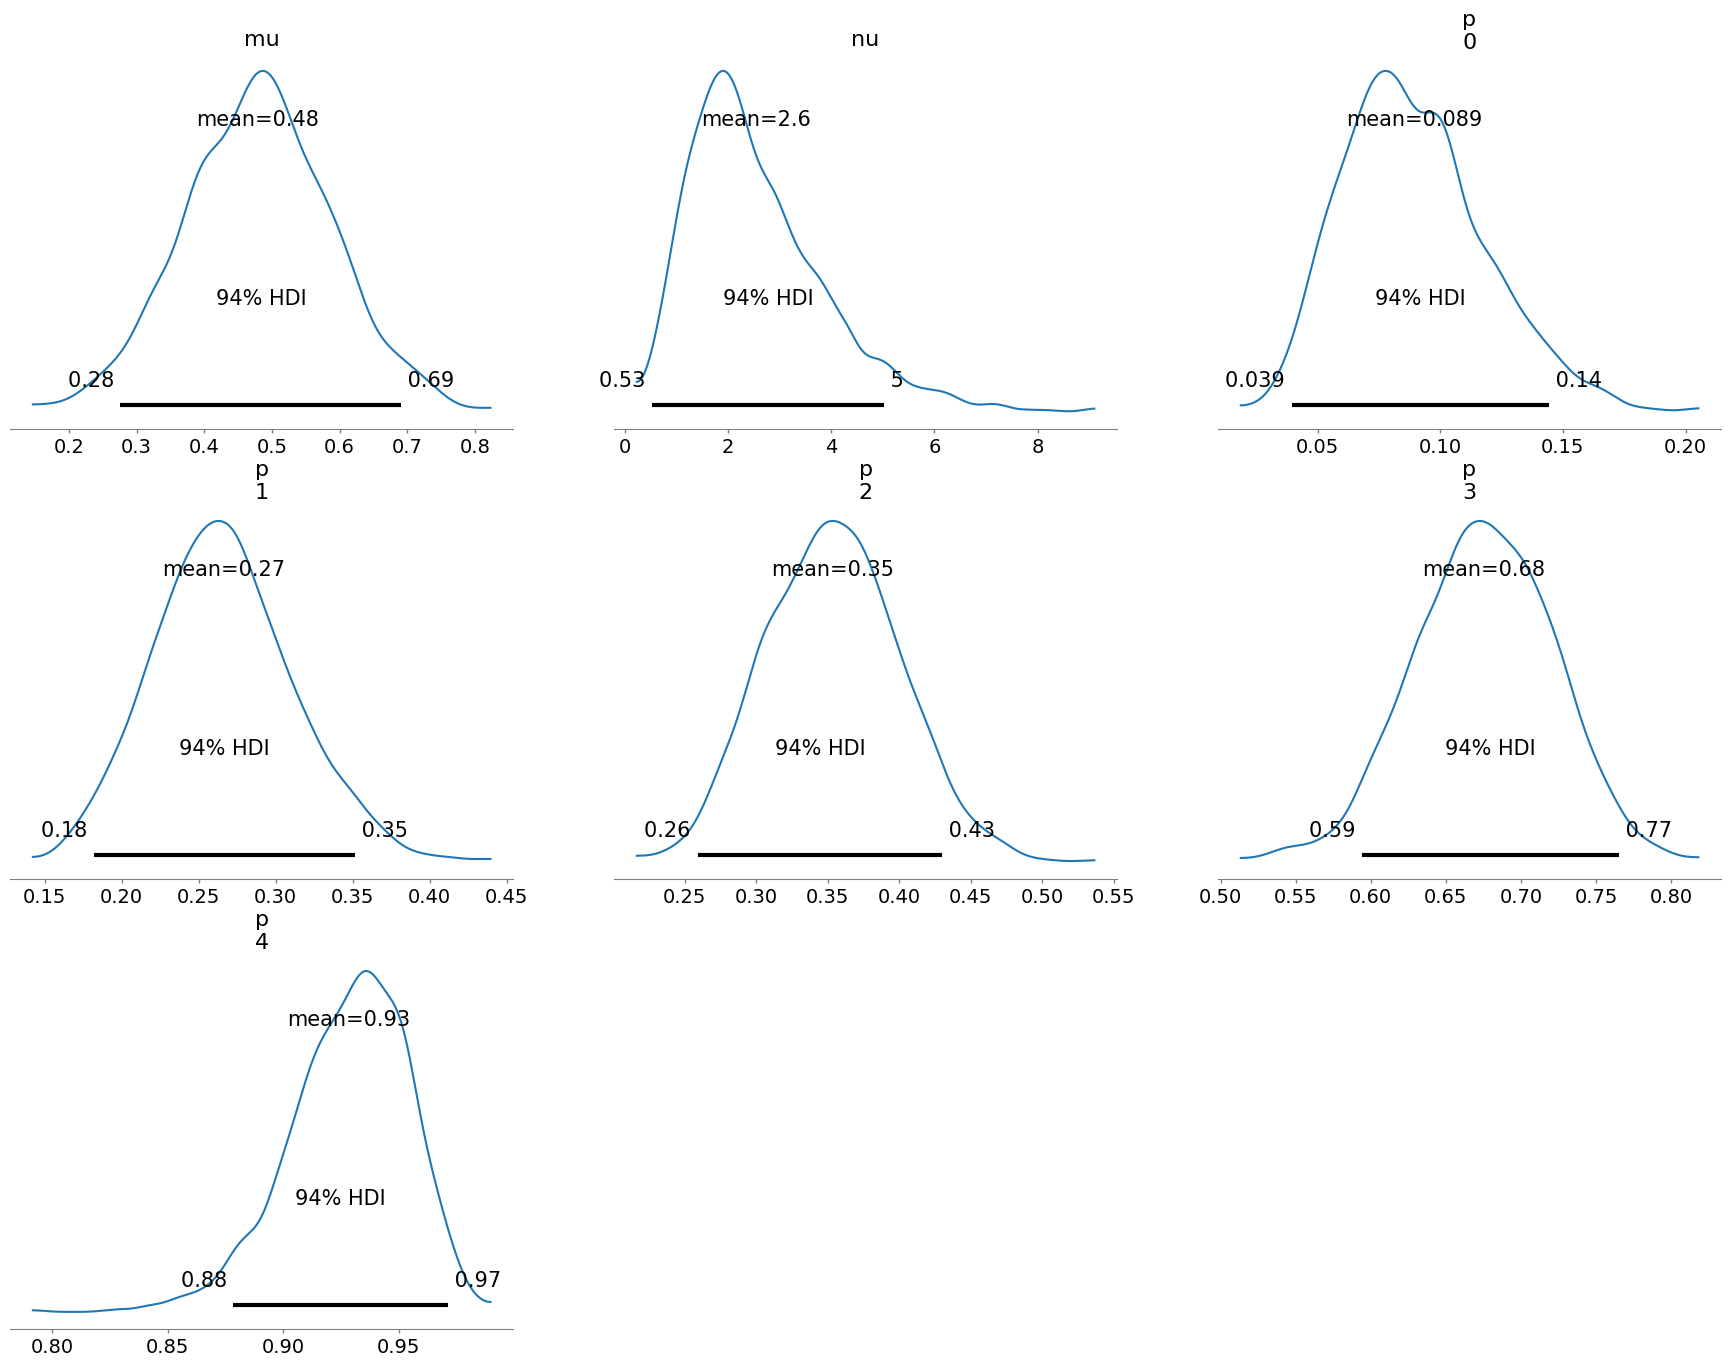

In [18]:
az.plot_posterior(idata_h)

### We can compare the two models using "AIC".

In [19]:
cmp_df = az.compare({"ind": idata_vec, "h": idata_h},ic="waic")

print(cmp_df)

     rank   elpd_waic    p_waic  elpd_diff  weight         se       dse  \
ind     0 -240.261313  4.831435   0.000000     1.0  12.023121  0.000000   
h       1 -240.475699  4.982190   0.214386     0.0  11.944091  0.115735   

     warning scale  
ind    False   log  
h      False   log  


#### And since we got a test result a bit lower on the independent model (looking at elpd_waic) we know that it is better. 

## Regression in bayesian Analysis
#### We have several ways to do regression, we'll start with the easiest, which is just calculting the mean(mu).

#### We'll start by generating data:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


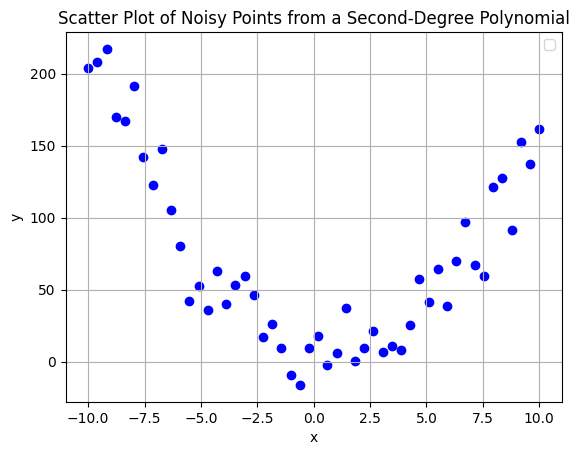

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the second-degree polynomial
a = 2
b = -3
c = 1

# Generate 50 random x values
x = np.linspace(-10, 10, 50)

# Compute corresponding y values from the polynomial
y = a * x**2 + b * x + c

# Add noise to the y values
noise = np.random.normal(0, 20, size=y.shape)  # Mean 0, Standard deviation 10
y_noisy = y + noise

# Plot the points
plt.scatter(x, y_noisy, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Noisy Points from a Second-Degree Polynomial')
plt.legend()
plt.grid(True)
plt.show()


#### calculate mean:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<Axes: title={'center': 'mu'}>

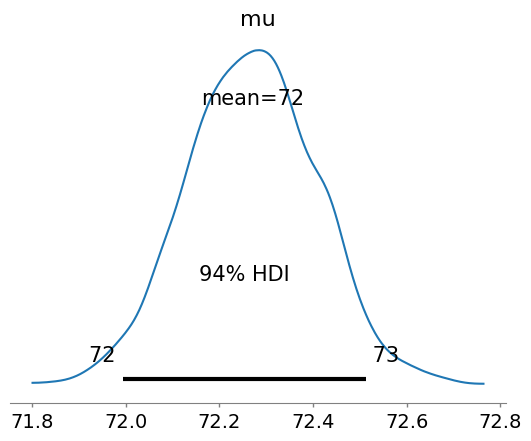

In [21]:
with pm.Model() as mean:
    
    # Priors for unknown parameters
    mu_mu = np.mean(y_noisy)  
    sigma_mu = np.std(y_noisy)  

    mu = pm.Normal('mu', mu=mu_mu, sigma=sigma_mu)
    
    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=1, observed=y_noisy)
    
    # Sampling
    idata = pm.sample(1000, chains=2)


az.plot_posterior(idata, var_names=['mu'])

#### And we have the mean, which is 67. 
#### we try a diffent approach, using the grid method.

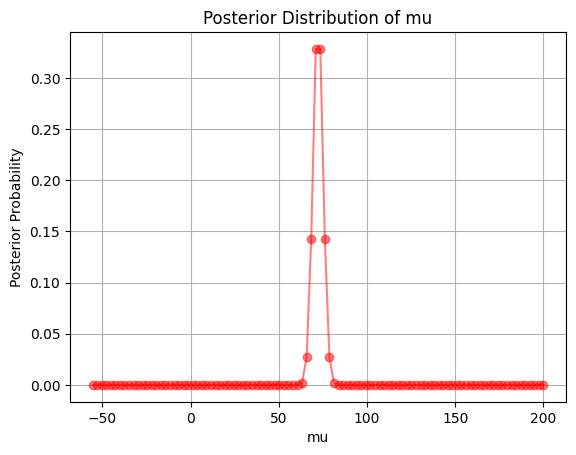

In [22]:
# Support for mu
mu_sup = np.linspace(mu_mu - 2 * sigma_mu, mu_mu + 2 * sigma_mu, n)

# Prior distribution over mu
prior = stats.norm.pdf(mu_sup, loc=mu_mu, scale=sigma_mu)

# Initialize the likelihood array
likelihood = np.empty(mu_sup.shape)

# Calculate likelihood for each value in the grid
for i in range(n):
    likelihood[i] = stats.norm.pdf(y_noisy, loc=mu_sup[i], scale=20).prod()

# Calculate the posterior distribution
posterior = prior * likelihood
posterior /= posterior.sum()  # Normalize the posterior

# Plot the posterior distribution
plt.plot(mu_sup, posterior, 'ro-', alpha=0.5)
plt.xlabel('mu')
plt.ylabel('Posterior Probability')
plt.title('Posterior Distribution of mu')
plt.grid(True)
plt.show()

#### We can see that we got a better result, since our variance is lower and we are more "sure" what is the true mean of mu.

### So far we've shown how to predict the mean on 1 dimention. 
### Let's see how we can predict a line of prediction and not just a scalar.
#### We need to predict two things: intercept and slope. (the slope is a 2d parameter, since we have a second degree Polynomial)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intcpt, slope1, slope2]


Output()

Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


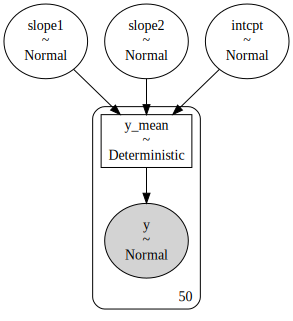

In [23]:
with pm.Model() as regress:
    # Priors for the coefficients 
    intcpt = pm.Normal('intcpt', 0, 10)
    slope1 = pm.Normal('slope1', 0, 10)  # Coefficient for x
    slope2 = pm.Normal('slope2', 0, 10)  # Coefficient for x^2
    
    # Deterministic variable for the mean of y based on the second-degree polynomial
    y_mean = pm.Deterministic("y_mean", intcpt + slope1 * x + slope2 * x**2)
    
    # Likelihood function, with observed data
    y = pm.Normal('y', mu=y_mean, sigma=20, observed=y_noisy)
    
    # Sample from the posterior distribution
    idata = pm.sample(3000, chains=2)
    
# Visualize the model structure
pm.model_to_graphviz(regress)


#### and plotting our results for slope and intercept:

array([<Axes: title={'center': 'intcpt'}>,
       <Axes: title={'center': 'slope1'}>,
       <Axes: title={'center': 'slope2'}>], dtype=object)

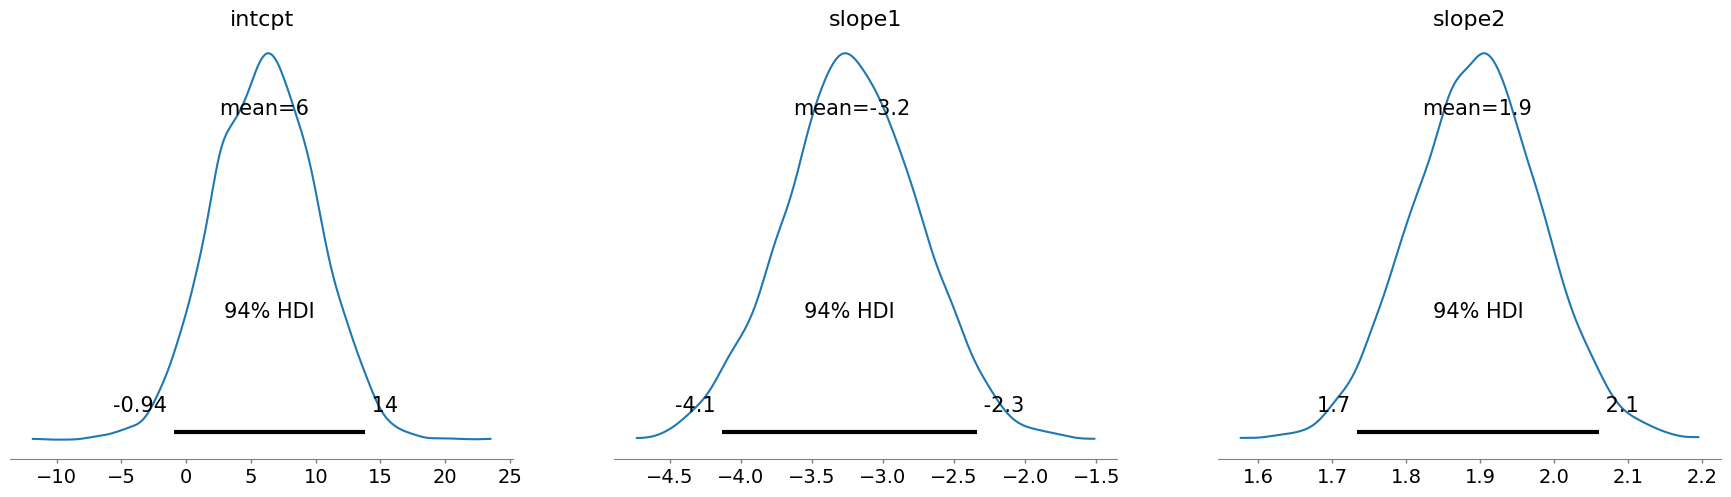

In [24]:
az.plot_posterior(idata,var_names=["~y_mean"])

#### We can plot the results side by side, for every parametar we have.

array([[<Axes: ylabel='slope1'>, <Axes: >],
       [<Axes: xlabel='intcpt', ylabel='slope2'>,
        <Axes: xlabel='slope1'>]], dtype=object)

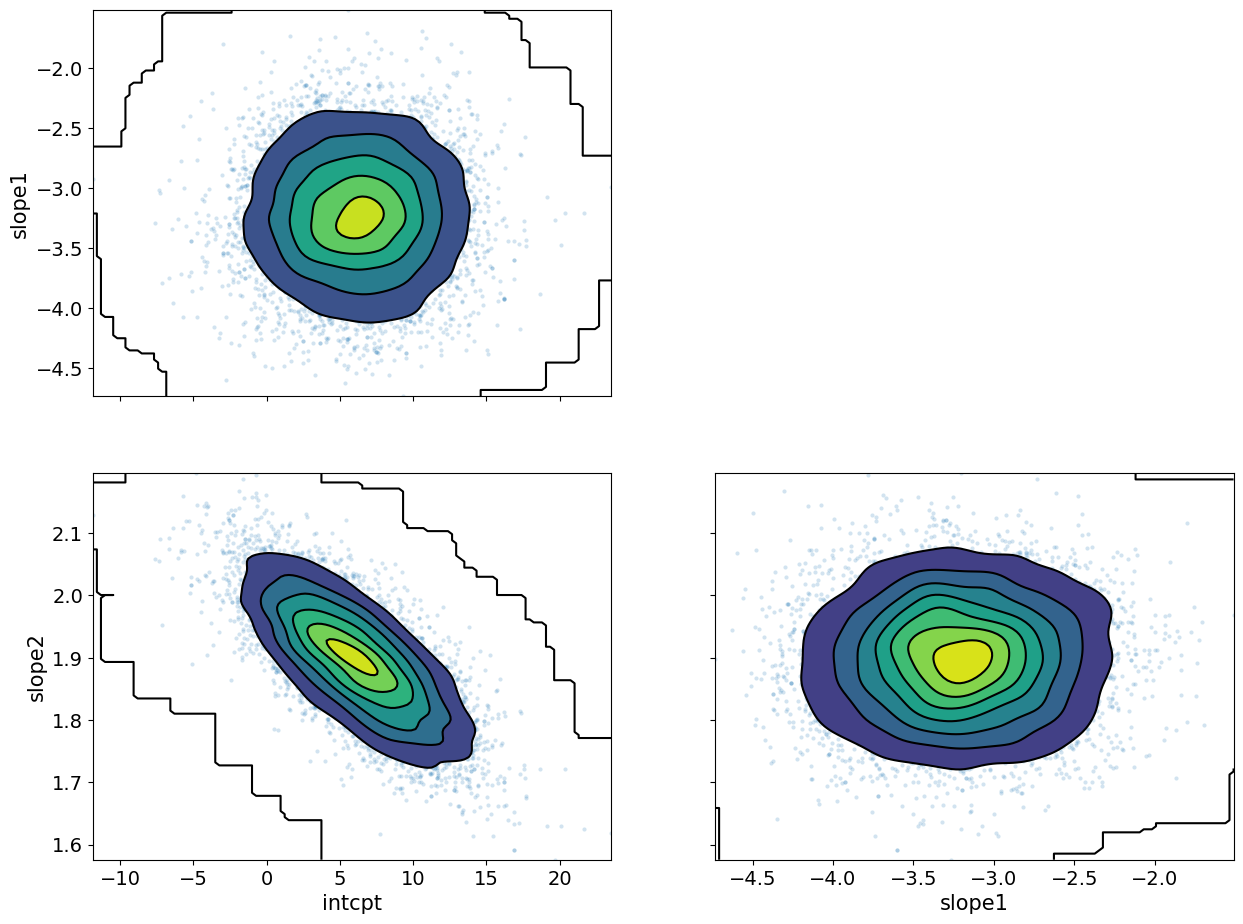

In [25]:
az.plot_pair(idata, var_names=["~y_mean"], kind=["kde", "scatter"], scatter_kwargs=dict(alpha=0.2))

#### We can plot it manually (notice I ingorned slope2, just becuase I don't want to plot 4d data)

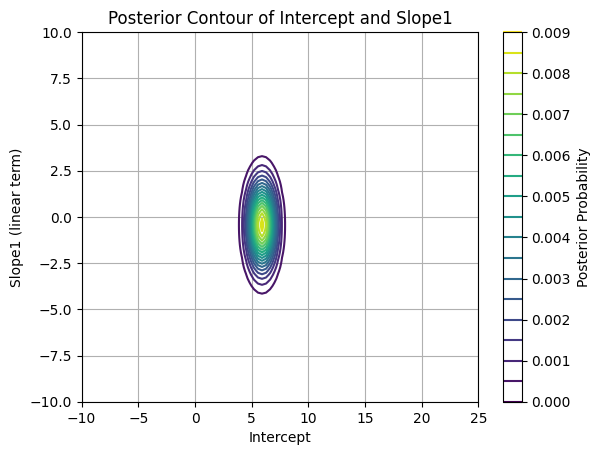

In [33]:
n = 100

# Define the grid for the intercept and slope1 parameters
intcpt_sup = np.linspace(-10, 25, n)  # Adjust range based on expected intercept
slope1_sup = np.linspace(-10, 10, n)  # Adjust range based on expected slope1

# Define priors for the intercept and slopes
prior_intcpt = stats.norm.pdf(intcpt_sup, loc=0, scale=10)
prior_slope1 = stats.norm.pdf(slope1_sup, loc=0, scale=10)

# Initialize likelihood and posterior arrays
likelihood = np.empty((n, n))
posterior = np.empty((n, n))

# Compute the likelihood and posterior for each combination of parameters
for i in range(n):
    for j in range(n):
        y_mean = intcpt_sup[i] + slope1_sup[j] * x
        likelihood[i, j] = stats.norm.pdf(y_noisy, loc=y_mean, scale=20).prod()
        posterior[i, j] = prior_intcpt[i] * prior_slope1[j] * likelihood[i, j]

# Normalize the posterior
posterior_sum = posterior.sum()
if posterior_sum > 0:
    posterior /= posterior_sum
else:
    print("Warning: Posterior sum is zero!")

# Plotting the 2D contour for intercept and slope1
plt.contour(intcpt_sup, slope1_sup, posterior, levels=20)
plt.xlabel('Intercept')
plt.ylabel('Slope1 (linear term)')
plt.title('Posterior Contour of Intercept and Slope1')
plt.colorbar(label='Posterior Probability')
plt.grid(True)
plt.show()


#### Remark: this method works here, but If I were to predict also slope2, the diffictuly will spike. 
#### In cases where our data has several variables to calculate, this will take too much time.

### Let's move on to different data
#### We'll generate data like we did in the lecture:

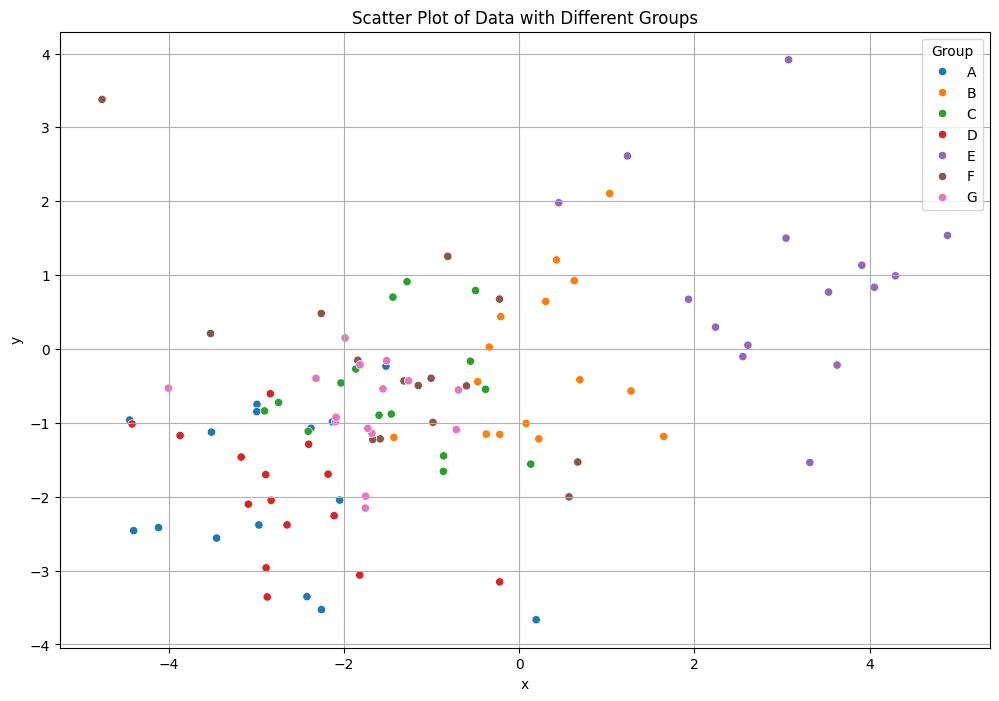

In [38]:
import seaborn as sns
np.random.seed(50)

# Parameters
group_list = ["A", "B", "C", "D", "E", "F", "G"]  # Increased number of groups
trials_per_group = 15  # Increased number of trials per group

# Generate group-specific parameters
group_intercepts = np.random.normal(0, 1, len(group_list))
group_slopes = np.ones(len(group_list)) * -0.3  # Adjusted slope for downward trend
group_mx = group_intercepts * 2

# Create the data
group = np.repeat(group_list, trials_per_group)
subject = np.concatenate([np.ones(trials_per_group) * i for i in np.arange(len(group_list))]).astype(int)
intercept = np.repeat(group_intercepts, trials_per_group)
slope = np.repeat(group_slopes, trials_per_group)
mx = np.repeat(group_mx, trials_per_group)

# Generate x and y values
x = np.random.normal(mx, 1)
y = np.random.normal(intercept + (x - mx) * slope, 1)

# Create DataFrame
data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x="x", y="y", hue="group", palette="tab10", marker="o")
plt.title('Scatter Plot of Data with Different Groups')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(title='Group')
plt.grid(True)
plt.show()


#### We can perform simple linear regression:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, β0, β1]


Output()

Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


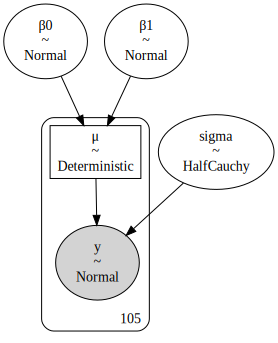

In [43]:
with pm.Model() as linear_regression:
    sigma = pm.HalfCauchy("sigma", beta=2)
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    
    μ = pm.Deterministic("μ", β0 + β1 * data.x)
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y)
    
    trace = pm.sample(3000, tune=1000, cores=2, return_inferencedata=True)

# Visualize the model
pm.model_to_graphviz(linear_regression)



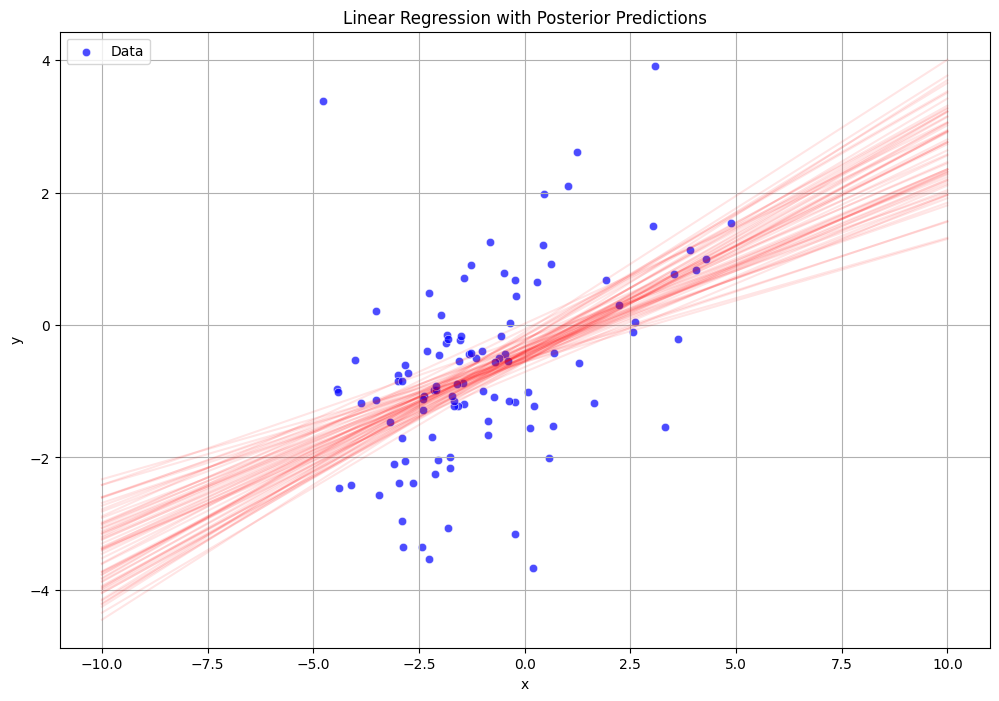

In [49]:
intercepts = trace.posterior["β0"].values.flatten()
slopes = trace.posterior["β1"].values.flatten()

# Generate predictions from posterior samples
x = np.linspace(-10, 10, 50)
x_range = np.linspace(x.min(), x.max(), 100)
plt.figure(figsize=(12, 8))

# Scatter plot of the data
sns.scatterplot(data=data, x="x", y="y", color="blue", label="Data", alpha=0.7)

# Plot regression lines based on posterior samples
for intercept, slope in zip(intercepts[::100], slopes[::100]):  # Plot every 100th sample for clarity
    plt.plot(x_range, intercept + slope * x_range, color='red', alpha=0.1)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression with Posterior Predictions')
plt.legend()
plt.grid(True)
plt.show()

#### But, we didn't take into acount the fact that the data was sampeld as part of groups. so let's try to use it.
### Hierarchical regression

/home/yair/.local/lib/python3.10/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept_mu, intercept_sigma, slope_mu, slope_sigma, sigma_hyperprior, sigma, β0, β1]


Output()

Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 17 seconds.
There were 620 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


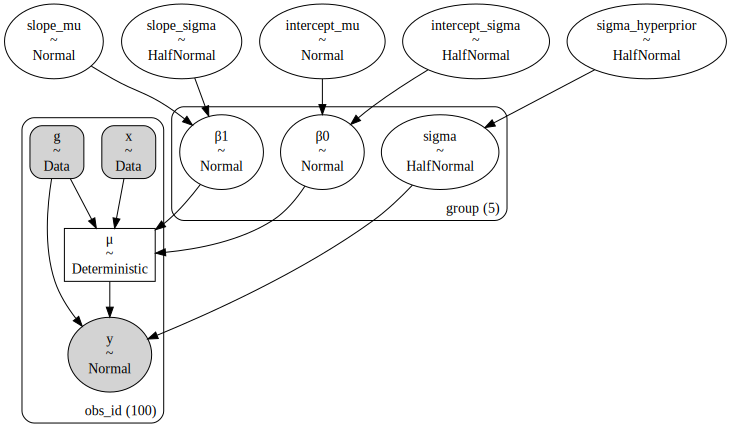

In [51]:
np.random.seed(42)
group_list = ["one", "two", "three", "four", "five"]
trials_per_group = 20
group_intercepts = np.random.normal(0, 1, len(group_list))
group_slopes = np.ones(len(group_list)) * -0.5
group_mx = group_intercepts * 2
group = np.repeat(group_list, trials_per_group)
subject = np.concatenate([np.ones(trials_per_group) * i for i in np.arange(len(group_list))]).astype(int)
intercept = np.repeat(group_intercepts, trials_per_group)
slope = np.repeat(group_slopes, trials_per_group)
mx = np.repeat(group_mx, trials_per_group)
x = np.random.normal(mx, 1)
y = np.random.normal(intercept + (x - mx) * slope, 1)
data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})

# Define the coordinates
coords = {"group": group_list}

# Fit the hierarchical model
with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")
    β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
    β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")
    
    # Sample from the posterior
    idata = pm.sample(3000, tune=1000, cores=2, return_inferencedata=True)

# Plot the model graph
pm.model_to_graphviz(hierarchical)

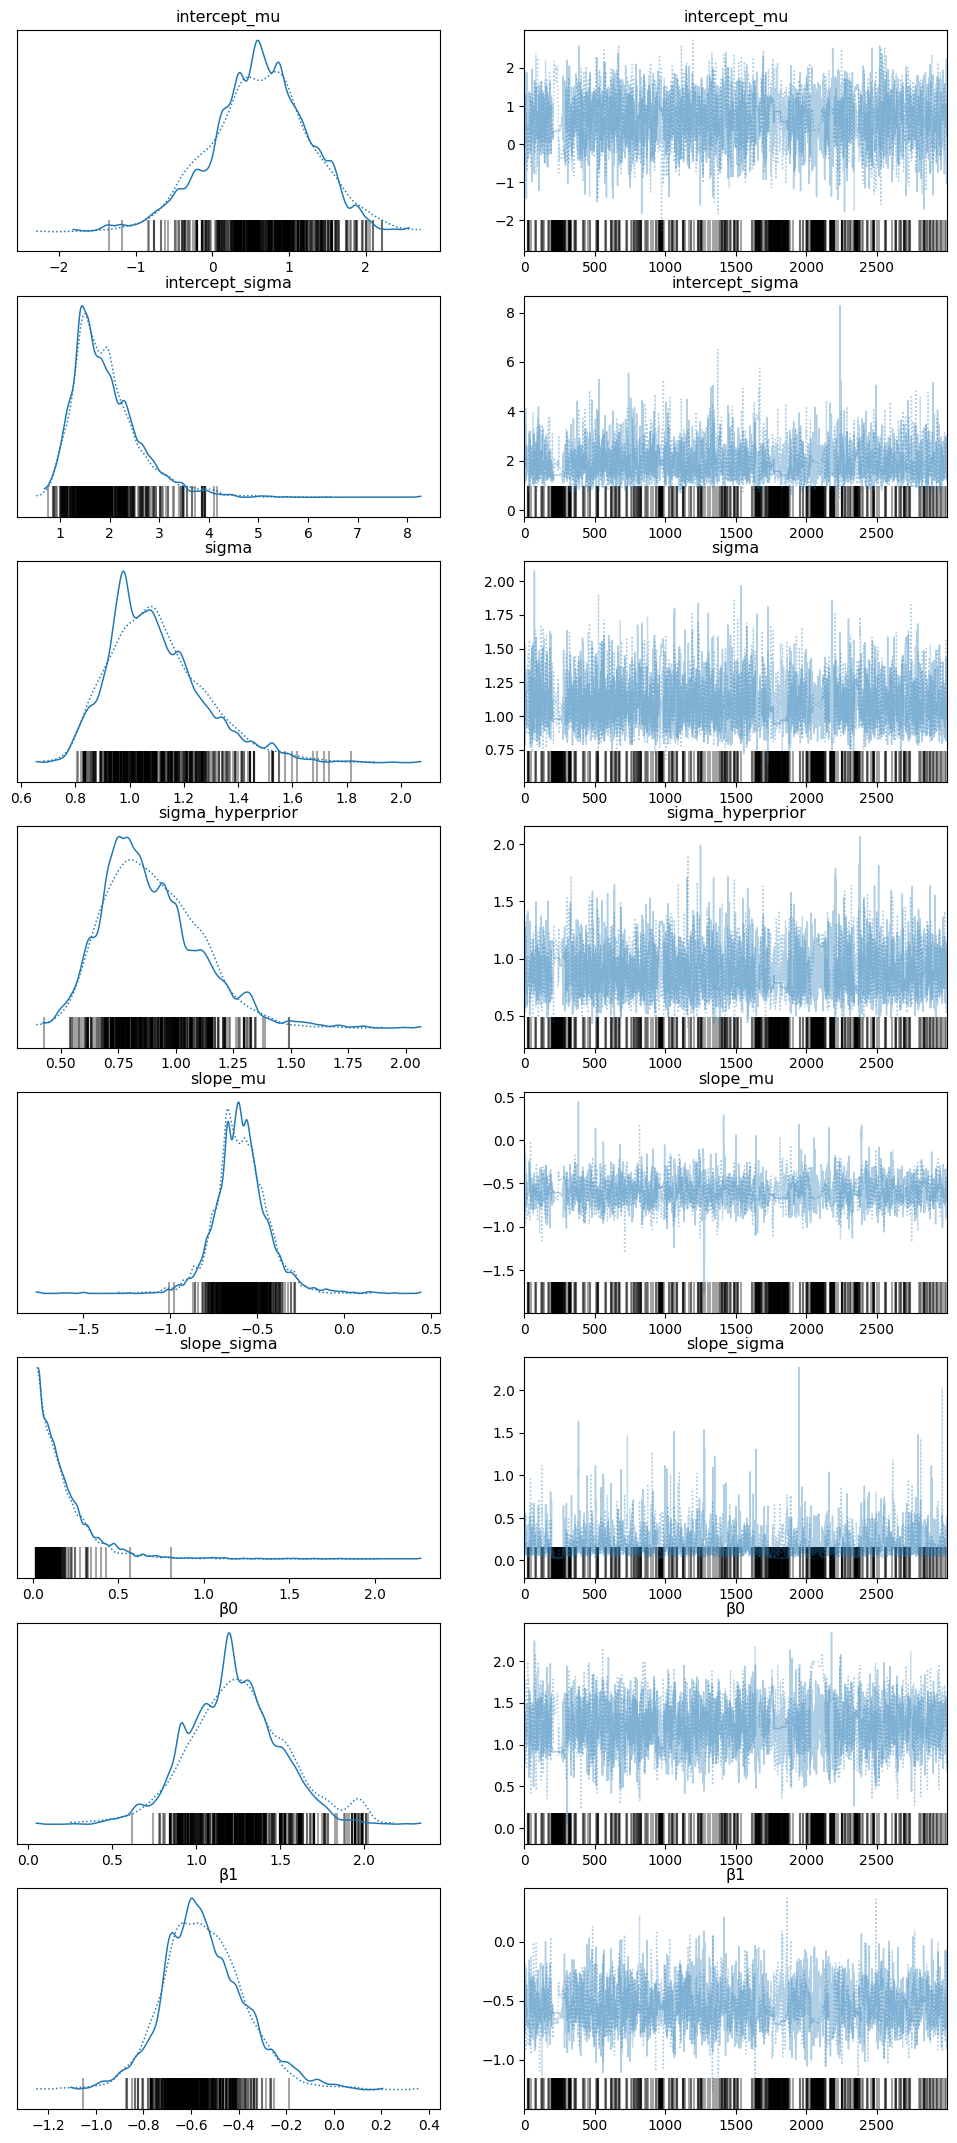

In [54]:
az.plot_trace(idata, var_names=["~μ"],coords = {"group": "one"},  figsize = (12, 9 * 3));

#### We got predicted results that are quite close to each other, indicating that we did a good job at predicting (for the two chains we used).
#### We can use some numerical measurments to check how good was the predicting:


In [55]:
az.summary(idata,var_names=["β1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β1[one],-0.544,0.175,-0.845,-0.184,0.005,0.003,1402.0,3197.0,1.0
β1[two],-0.608,0.170,-0.936,-0.287,0.004,0.002,2207.0,3442.0,1.0
β1[three],-0.607,0.164,-0.918,-0.281,0.003,0.002,2043.0,3565.0,1.0
β1[four],-0.616,0.154,-0.902,-0.322,0.004,0.003,1736.0,2677.0,1.0
β1[five],-0.622,0.180,-0.976,-0.282,0.004,0.003,2368.0,3635.0,1.0


#### Looking at ess_bulk, we can see that out of 3000 examples that we sampled, we "used" 1402 of them, and this is not too bad.
#### We can look at the graph of ess:

<Axes: title={'center': 'β1'}, xlabel='Total number of draws', ylabel='ESS'>

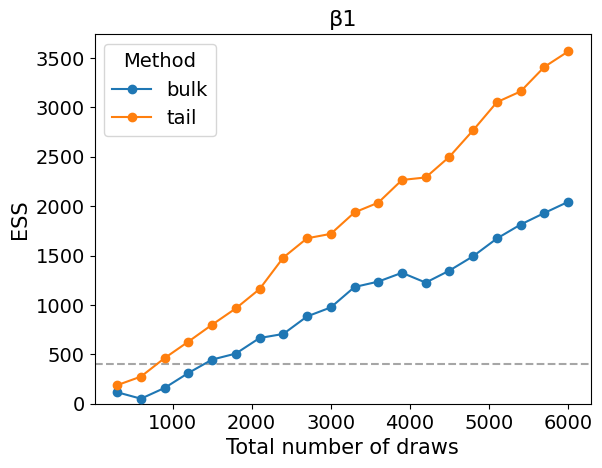

In [56]:
az.plot_ess(idata,var_names=["β1"],coords = {"group": "three"},kind='evolution')

#### And we get what we want, which is a steady increase in the graph.

#### let's say that I'm still not satisfied with how accurate my prediction is. I try and fix it using two ways.

#### 1: the most simple one is to increase the number of samples. we saw that the more samples we get, the higher the ess is
#### 2: we can use the same model, just defined differently.

In [60]:
with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")
    β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
    β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")
    
    # Sample from the posterior
    idata = pm.sample(5000, tune=1000, cores=2, return_inferencedata=True) #changed to 5000 from 3000

/home/yair/.local/lib/python3.10/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept_mu, intercept_sigma, slope_mu, slope_sigma, sigma_hyperprior, sigma, β0, β1]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 23 seconds.
There were 1043 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [62]:
az.summary(idata,var_names=["β1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β1[one],-0.548,0.178,-0.858,-0.193,0.004,0.003,1829.0,1429.0,1.0
β1[two],-0.609,0.169,-0.926,-0.284,0.003,0.002,2401.0,5720.0,1.0
β1[three],-0.613,0.166,-0.914,-0.293,0.003,0.002,2093.0,5492.0,1.0
β1[four],-0.622,0.154,-0.902,-0.317,0.003,0.002,1997.0,4907.0,1.0
β1[five],-0.630,0.181,-0.987,-0.291,0.004,0.003,2349.0,4920.0,1.0


#### We can see that adding more samples did increaes the ess_bulk by around 400. 
#### Let's try the second method:

In [68]:
coords = {"group": group_list}

# Define and fit the hierarchical non-centered model
with pm.Model(coords=coords) as hierarchical_nc:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define non-centered priors for intercepts and slopes
    β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
    β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
    β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
    β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")

    # Define the data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")

    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    
    # Define likelihood
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

    # Sample from the posterior
    idata_nc = pm.sample(3000, tune=1000, cores=2, return_inferencedata=True)

/home/yair/.local/lib/python3.10/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept_mu, intercept_sigma, slope_mu, slope_sigma, sigma_hyperprior, β0_offset, β1_offset, sigma]


Output()

Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 28 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [69]:
az.summary(idata_nc,var_names=["β1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β1[one],-0.550,0.177,-0.873,-0.211,0.003,0.002,4530.0,3813.0,1.0
β1[two],-0.603,0.165,-0.920,-0.289,0.002,0.002,6101.0,4229.0,1.0
β1[three],-0.603,0.161,-0.919,-0.315,0.002,0.001,6020.0,4409.0,1.0
β1[four],-0.611,0.153,-0.909,-0.325,0.002,0.002,5013.0,3724.0,1.0
β1[five],-0.617,0.177,-0.956,-0.274,0.002,0.002,5334.0,4521.0,1.0


#### and we got a big leap in our result, by just using non-centered parametization. (ess_bulk is 4000+)